<a href="https://colab.research.google.com/github/KatalinaE/Optimization-methods/blob/main/%D0%94%D0%B7_%D0%93%D0%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.


\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [133]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(23)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)

Число обусловленности такой матрицы будет большим

In [134]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w)/min(w)

(406095.0426591316, 406095.04265891394)

In [135]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

In [136]:
def ConjugateGradient(x0, A, b, tol=1e-4, callback=None):
    x = x0
    r = b - A.dot(x0) 
    p = r
    while np.linalg.norm(r) > tol:
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        r_next = r - alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = r_next + beta * p
        r = r_next
        
        if callback is not None:
            callback(x)
            
    return x

class Counter:
  def __init__(self):
    self.count = 0
  
  def inc(self, *any):
    self.count += 1
  
  def get(self):
    return self.count

counter = Counter()

ConjugateGradient(x0, A, b, callback = counter.inc)
print(counter.get())

1000


Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 


![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [137]:
def PreconditionedCG(x0, A, b, M = np.diag(np.diag(A.toarray())), tol=1e-4, callback = lambda x: None):
    x = x0.copy()
    r = b - A @ x
    z = x
    z, prev_z = np.linalg.solve(M, r), z
    beta = 0
    p = z
    w = A @ p
    alpha = r.T @ z / (p.T @ w)
    x += alpha * p
    r, prev_r = r - alpha * w, r

    while True:   
        z, prev_z = np.linalg.solve(M, r), z
        beta = r.T @ z / (prev_r.T @ prev_z)
        p = z + beta * p
        w = A @ p
        alpha = r.T @ z / (p.T @ w)
        x += alpha * p
        r, prev_r = r - alpha * w, r
        
        callback(x)
            
        if np.linalg.norm(r) <= tol:
            break
        
    return x

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

In [138]:
L = np.tril(A.toarray())
U = np.triu(A.toarray())
D = np.diag(np.diag(A.toarray()))
invD = np.linalg.inv(D)

M = (D + L) @ (invD) @ (D + U)

counter = Counter()
PreconditionedCG(x0, A, b, M, callback = counter.inc)
print(counter.get())

630


Сравните результат работы предобусловленной и непредобусловленной версии.

Количество итераций в предобусловленной версии составляет 0,63 от непредобусловленной.

## Второе задание. Метод момента

Реализовать Метод момента.

![](Momentum.png)

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

In [139]:
import types
def backtracking(x, f, grad_f, rho, alpha0, beta1, beta2):
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:
            return alpha / rho
    return alpha

def MomentumGD(f, gradf, x0, momentum = 0.5, tol=1e-8, callback= lambda x: None, rho=0.5, beta1=0.2):
    x = x0.copy()
    conv_array = []
    change = np.zeros(x.shape)
    beta2 = 1 - beta1

    while True:
        alpha = backtracking(x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        change = momentum * change - alpha * gradient
        x = x + change
        
        if np.linalg.norm(gradf(x)) < tol:
            break
            
        callback(x)
        conv_array.append(x)
        
    return conv_array

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

In [140]:
#GradientDescent скопированный
def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3, momentum = 0, callback = lambda x: None):
    x = x0.copy()
    iteration = 0
    conv_array = []
  
    while True:
        beta2 = 1. -beta1

        alpha = backtracking(x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient

        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        callback(x)
        conv_array.append(x)
    return conv_array

def NesterovAcceleratedGD(f, gradf, x0, momentum =0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2, callback = lambda x: None):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)
   
    while True:
        beta2 = 1. -beta1

        proj = x + momentum * change
        
        gradient = gradf(proj)
        alpha = backtracking(x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
            
        callback(x)
        conv_array.append(x)
    return conv_array

In [141]:
sns.set()
np.random.seed(23)
n=100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-4, 4, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# строим изолинии
f_x = X.T @ A @ X - b @ X

f_x = np.diag(f_x).reshape(n_points, n_points)


# b I used  in my own experiments array([0.22104536, 0.68622209]) 

# начальное приближение
x0 = np.array([-4. , -4.])


# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

Plain 679
Nesterov 723
Momentum 786


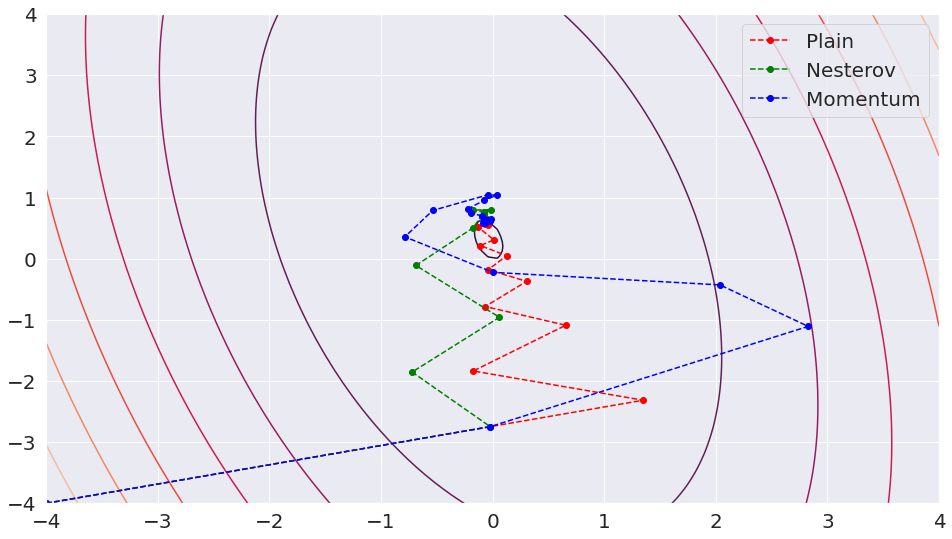

In [142]:
plt.figure(figsize = (16, 9))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.contour(x, y, f_x)

def get_x_and_y(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for a in array:
        x_array.append(a[0])
        y_array.append(a[1])
    return np.array(x_array), np.array(y_array)

colors = ["red", "green", "blue"]
names = ["Plain", "Nesterov", "Momentum"]
gds = [GradientDescent, NesterovAcceleratedGD, MomentumGD]

for color, name, gd in zip(colors, names, gds):
    сounter = Counter()
    X, Y = get_x_and_y(gd(f, grad_f, x0, momentum = 0.5, callback=counter.inc), x0)
    print(name, counter.get())
    plt.plot(X, Y, '--o', label=name, color=color)

plt.legend(loc="best", fontsize=20)
plt.show()

**Вывод:** Метод Нестерова сходится лучше всего.